In [15]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

# Plot the waveform and spectrogram for a given sound sample array
def plot_waveform_and_spectrogram(sound_samples, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(sound_samples, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.xlim(left=0)
    plt.savefig('figures/waveform.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.ylim(0, 2048)
    D = librosa.amplitude_to_db(librosa.stft(sound_samples, n_fft=2048, hop_length=512), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.savefig('figures/spectrogram.pdf', bbox_inches='tight')
    plt.savefig('figures/spectrogram.svg', bbox_inches='tight')
    plt.show()

In [8]:
import os

default_path = r'C:\Users\pitte\Documents\Repositories\self_assembly_music\data_analysis'
os.chdir(default_path)

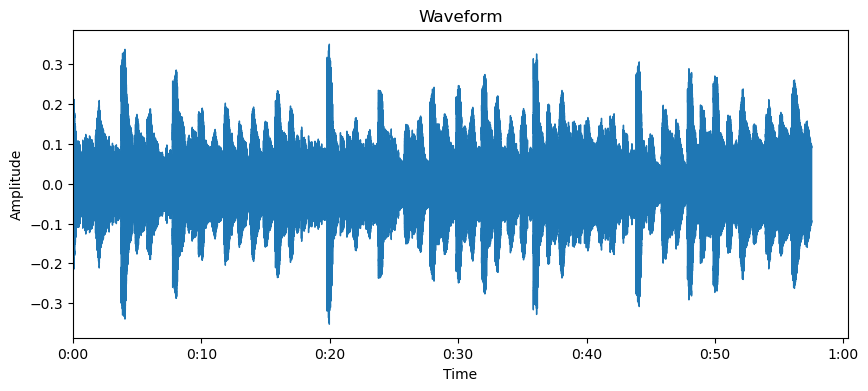

C:\Users\pitte\AppData\Local\Temp\ipykernel_16280\1244275205.py:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sound_samples, n_fft=2048, hop_length=512), ref=np.max)


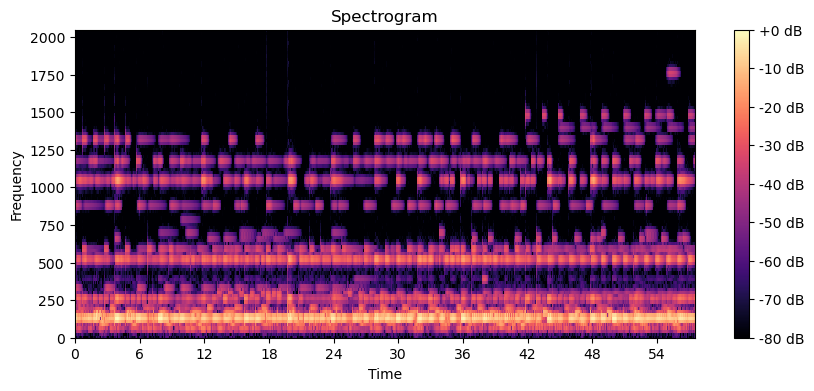

In [16]:
directory = "C:\\Users\\pitte\\Documents\\Recordings\\self-assembly1"
sr = 44100  # Sampling rate

def ShowPlots(file_name, sr):
    audio_file = file_name
    audio_path = directory + "\\" + audio_file
    audio_data, sr = librosa.load(audio_path, sr=sr)
    minute = 2
    plot_waveform_and_spectrogram(audio_data[int(2.5 * sr) + 60 * sr * minute:60 * sr * (minute + 1)], sr)

ShowPlots("self-assembly-paper-audio.wav", sr)

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def SyncErrorPerAgent(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Group the data by the "id" column
    grouped_data = df.groupby('id')

    # # Access each group
    # for group_name, group_data in grouped_data:
    #     print(f"Group: {group_name}")
    #     print(len(group_data.values))
    #print(len(grouped_data))
    agents_count = len(grouped_data)
    all_mean_differences = []

    for reference_group_name in range(1, agents_count + 1):
        reference_timestamps = grouped_data.get_group(reference_group_name)['time'].values
        mean_differences = []

        for reference_time in reference_timestamps:

            # Initialize an empty list to store the average distances
            min_distances_per_other_agent = []

            # Iterate over each group
            for group_name, group_data in grouped_data:
                if group_name == reference_group_name:
                    continue
                # Get the sample times in the current group
                sample_times = group_data['time']
                
                # Calculate the absolute differences between the first time and sample times
                min_abs_differences = np.abs(sample_times - reference_time).min()
                
                # Append the average distance to the list
                min_distances_per_other_agent.append(min_abs_differences)

            # Append the average distance to the list
            mean_differences.append(np.array(min_distances_per_other_agent).mean())

        #print(len(mean_differences))
        all_mean_differences.append(mean_differences)

    return all_mean_differences



def PlotSyncError(all_mean_differences, save_file = False, agents_size = 0, file_path_fig = 'figures/'):
    plt.figure(figsize=(10, 4))
    min_len = sys.maxsize
    for mean_differences in all_mean_differences:
        plt.plot(mean_differences)
        len_means = len(mean_differences)
        if len_means < min_len:
            min_len = len_means    

    
    # Set the labels for the x-axis and y-axis
    plt.xlabel('Time (s)')
    plt.ylabel('Desynchronization Degree (s)')

    # Set the title of the graph
    title = 'Desynchronization Degrees for '+str(agents_size)+' Agents over time'
    plt.title(title)
    
    if save_file:
        # Save the graph to a file
        plt.savefig(file_path_fig + title + '.pdf', bbox_inches='tight')

    plt.show()
    # final_mean_differences = np.zeros(min_len)
    # for mean_differences in all_mean_differences:
    #     final_mean_differences += mean_differences[:min_len]
    # final_mean_differences /= len(all_mean_differences)        
    # plt.plot(final_mean_differences)
    # plt.show()
    


In [3]:
#Generate sync error files
import os
import pickle

directory = 'data/sync_struct_5_100/'
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("SYNC"): 
            file_path = os.path.join(root, file)
            all_mean_differences = SyncErrorPerAgent(file_path)
            file_path_diff = os.path.join(root, 'DIFF-' + file[:-4] + '.pkl')
            with open(file_path_diff, "wb") as file:
                pickle.dump(all_mean_differences, file)

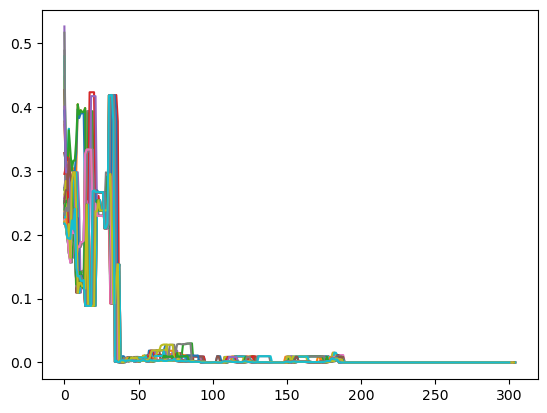

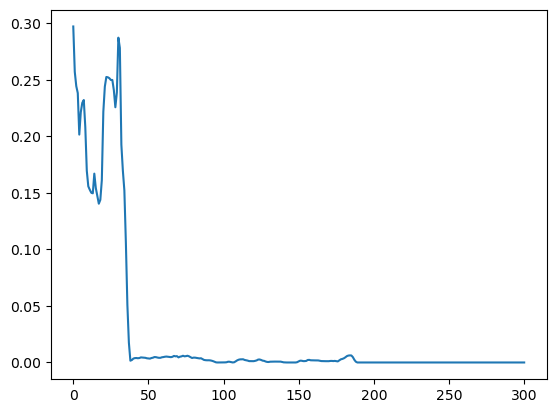

In [8]:
file_directory = 'data/'
file_name = '2024_04_26_18_58_04-N-50-minspeed-2-maxspeed-2-maxjointtime-10-joinradiusfactor-2-maxjointssize-6-radiusboundary-2-freq-1.csv'
PlotSyncError(file_directory, file_name)

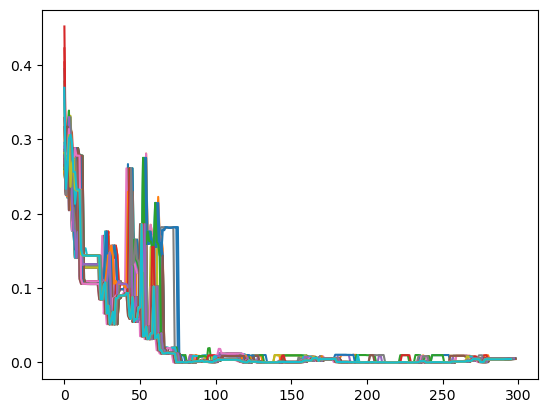

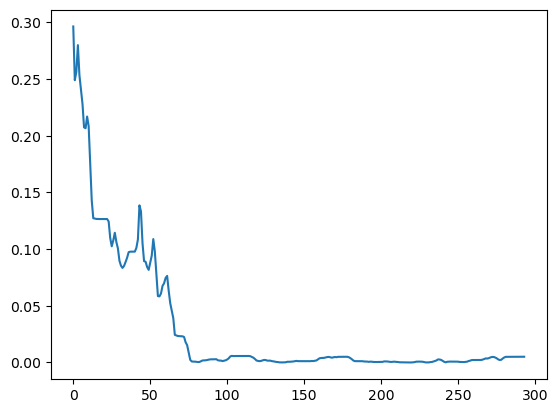

In [9]:
file_directory = 'data/'
file_name = '2024_04_26_19_03_43-N-50-minspeed-2-maxspeed-2-maxjointtime-10-joinradiusfactor-2-maxjointssize-6-radiusboundary-2-freq-1.csv'
PlotSyncError(file_directory, file_name)

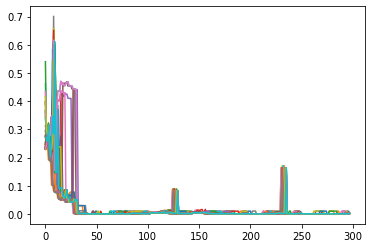

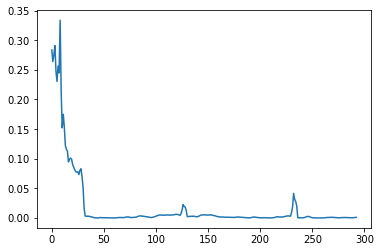

In [4]:
file_directory = 'data/'
file_name = 'SYNC-2024_04_28_12_32_24-N-50-minspeed-2-maxspeed-2-maxjointtime-5-joinradiusfactor-2-maxjointssize-6-radiusboundary-2-freq-1.csv'
PlotSyncError(file_directory, file_name)

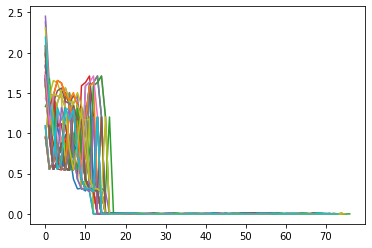

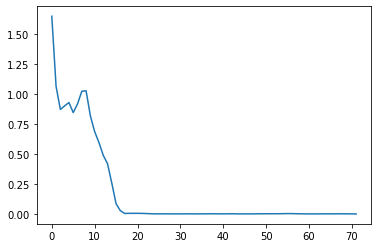

In [5]:
file_directory = 'data/'
file_name = 'SYNC-2024_04_28_12_33_23-N-50-minspeed-2-maxspeed-2-maxjointtime-5-joinradiusfactor-2-maxjointssize-6-radiusboundary-2-freq-0.25.csv'
PlotSyncError(file_directory, file_name)

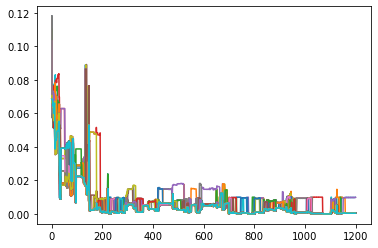

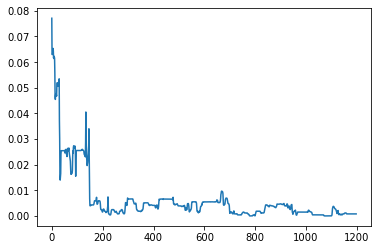

In [6]:
file_directory = 'data/'
file_name = 'SYNC-2024_04_28_12_36_01-N-50-minspeed-2-maxspeed-2-maxjointtime-5-joinradiusfactor-2-maxjointssize-6-radiusboundary-2-freq-4.csv'
PlotSyncError(file_directory, file_name)

data/first_collections\DIFF-SYNC-2024_04_28_12_32_24-N-50-minspeed-2-maxspeed-2-maxjointtime-5-joinradiusfactor-2-maxjointssize-6-radiusboundary-2-freq-1.pkl


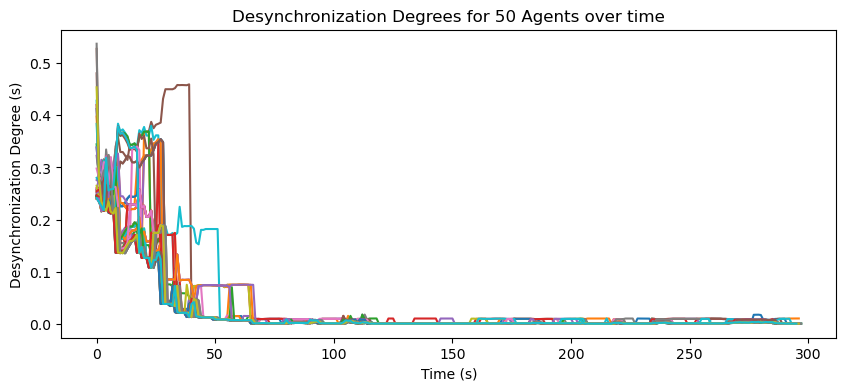

In [4]:
import pickle

# Specify the file path
#file_path = "C:/Users/Pedro/Documents/PhD_RITMO/Repositories/self_assembly_music/data_analysis/data/sync_struct_5_100/size-50-join-5/DIFF-SYNC-2024_05_05_09_14_52-N-50-ls-1-hs-1-wt-1-jt-5-jr-2-js-6-rb-2-f-1.pkl"
file_path = "C:/Users/pitte/Documents/Repositories/self_assembly_music/data_analysis/data/sync_struct_5_100/size-50-join-5/DIFF-SYNC-2024_05_05_09_14_52-N-50-ls-1-hs-1-wt-1-jt-5-jr-2-js-6-rb-2-f-1.pkl"

# Load the data from the file
with open(file_path, "rb") as file:
    sync_errors = pickle.load(file)

# Print the retrieved array
PlotSyncError(sync_errors, save_file = True, agents_size = 50, file_path_fig = 'C:/Users/pitte/Documents/Repositories/self_assembly_music/data_analysis/figures/')
